# Prepare data for Chicago

I will investigate the data here to make sure it will work well in Glue.  

In [134]:
#import libraries that will be needed for the data exploration (including the map)
import numpy as np
import pandas as pd
import zipfile
import os
import requests
import matplotlib.pyplot as plt
from dateutil import parser

from PIL import Image

from osgeo import gdal
from osgeo import osr

import rasterio
from rasterio.plot import show as showRasterio

import geopandas as gpd

from astropy.time import Time

%matplotlib inline

# [Chicago Data Portal](https://data.cityofchicago.org/)

*Note: This also seems like a nice place to find Chicago data.*
https://libguides.northwestern.edu/c.php?g=115072&p=7091162

## Transportation / [Taxi Trips](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew/data)

I started to download the full dataset, but this is a rather large file (about 198 million lines)!  I'll limit this online to only after 2021 (about 3 million lines).  Then here I will only include the columns that I need for Glue.  But note that this only has central longitude and latitudes, so it is not as interesting to plot on the map.

In [64]:
df = pd.read_csv('Taxi_Trips.csv')
df

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,1140.0,6.40,NaN,NaN,28.0,6.0,...,0.0,25.35,Credit Card,Medallion Leasin,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014)
1,3adf277e43154ac0cd099c7bb7137f75dcfded95,d24314a66ebc6319a50cc335d6896612b845ca15f702ee...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,420.0,1.30,NaN,NaN,8.0,8.0,...,0.0,7.00,Cash,Top Cab Affiliation,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,352e025da59c35567204a5025d0a7ebbb41e7e93,67d5ca2736337fa9f349db0f29887fe290c0cd84263055...,01/01/2021 12:15:00 AM,01/01/2021 12:30:00 AM,660.0,4.70,NaN,NaN,7.0,3.0,...,0.0,14.25,Cash,Medallion Leasin,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
3,3276bc172c61ea58ce803d2f34611f6c074c14f1,35057a271731c5b976bda25efe85aa0c1901d0a5fc9ba2...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,0.0,0.00,NaN,NaN,8.0,8.0,...,0.0,25.03,Credit Card,Chicago Independents,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
4,46e7d47c11aa83bc3488d7df84f901a92b961461,19e804a8eab9224b352e6a384007418b519864a3e7c2d9...,01/01/2021 12:15:00 AM,01/01/2021 12:15:00 AM,199.0,1.10,NaN,NaN,14.0,13.0,...,0.0,5.75,Cash,Medallion Leasin,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.983636,-87.723583,POINT (-87.7235831853 41.9836363072)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3072448,d47578fccfeb6baf436f3f3712554f734ba1b8b4,33c877ad242c484ce01ba5a4447f4b699eb84d5c9a3efa...,11/01/2021 12:00:00 AM,11/01/2021 12:15:00 AM,1560.0,18.20,NaN,NaN,76.0,32.0,...,4.0,59.20,Credit Card,U Taxicab,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
3072449,d63d8537ba0a001a3173304f2ce35a9d5cfea531,b15d5dba7f578c2e93e08c66d7a9b57bc35c9f316265cb...,11/01/2021 12:00:00 AM,11/01/2021 12:15:00 AM,900.0,4.20,NaN,NaN,32.0,24.0,...,2.0,19.60,Credit Card,"Taxicab Insurance Agency, LLC",41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
3072450,ed11b122ca4de5b2ab13bd420c845269dc6df937,d2c2d4128d6597a3b6db0bd0efa96e9914be3994f861bb...,11/01/2021 12:00:00 AM,11/01/2021 12:00:00 AM,347.0,1.09,NaN,NaN,6.0,3.0,...,0.0,8.10,Mobile,Flash Cab,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
3072451,fc4280b46018157c8976e70a958687ade1c1d41f,6607f4be1b8737ffe33ac1f71d10d1132541d86cd00c1d...,11/01/2021 12:00:00 AM,11/01/2021 12:15:00 AM,917.0,4.48,NaN,NaN,6.0,22.0,...,0.0,14.50,Cash,Flash Cab,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205)


In [65]:
date = []
for index, row in df.iterrows():   
    dt = parser.parse(row['Trip Start Timestamp'])
    t = Time(dt)
    date.append(t.decimalyear)

In [ ]:
out = pd.DataFrame()
out['Start Time'] = date
out['Minutes'] = df['Trip Seconds']/60
out['Miles'] = df['Trip Miles']
out['Total Paid ($)'] = df['Trip Total']
out['Tips ($)'] = df['Tips']
out['Company'] = df['Company']
out['Pickup Centroid Latitude'] = df['Pickup Centroid Latitude']
out['Pickup Centroid Longitude'] = df['Pickup Centroid Longitude']
out['Dropoff Centroid Latitude'] = df['Dropoff Centroid Latitude']
out['Dropoff Centroid Longitude'] = df['Dropoff Centroid Longitude']

out.to_csv('ChicagoTaxi.csv', index=False)

In [67]:
out

,Start Time,Minutes,Miles,Total Paid ($),Tips ($),Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,2021.000029,19.000000,6.40,25.35,5.85,Medallion Leasin,41.874005,-87.663518,41.944227,-87.655998
1,2021.000029,7.000000,1.30,7.00,0.00,Top Cab Affiliation,41.899602,-87.633308,41.899602,-87.633308
2,2021.000029,11.000000,4.70,14.25,0.00,Medallion Leasin,41.922686,-87.649489,41.965812,-87.655879
3,2021.000029,0.000000,0.00,25.03,0.03,Chicago Independents,41.899602,-87.633308,41.899602,-87.633308
4,2021.000029,3.316667,1.10,5.75,0.00,Medallion Leasin,41.968069,-87.721559,41.983636,-87.723583
...,...,...,...,...,...,...,...,...,...,...
3072448,2021.832877,26.000000,18.20,59.20,9.95,U Taxicab,41.980264,-87.913625,41.878866,-87.625192
3072449,2021.832877,15.000000,4.20,19.60,3.35,"Taxicab Insurance Agency, LLC",41.878866,-87.625192,41.901207,-87.676356
3072450,2021.832877,5.783333,1.09,8.10,1.35,Flash Cab,41.944227,-87.655998,41.965812,-87.655879
3072451,2021.832877,15.283333,4.48,14.50,0.00,Flash Cab,41.944227,-87.655998,41.922761,-87.699155


### Take average values at the given latitude and longitudes

In [165]:
df = pd.read_csv('ChicagoTaxi.csv')
df = df[df['Pickup Centroid Latitude'].notna()]
uIndex =  np.unique(df['Pickup Centroid Latitude'].to_numpy(), return_index = True)[1]
uLat = df['Pickup Centroid Latitude'].iloc[uIndex].to_numpy()
uLon = df['Pickup Centroid Longitude'].iloc[uIndex].to_numpy()
print(len(uLat), len(uLon))

519 519


In [169]:
mmin = []
mmile = []
mpaid = []
mtips = []
nTrips = []
for lat,lon in zip(uLat, uLon):
    rows = df.loc[(df['Pickup Centroid Latitude'] == lat) & (df['Pickup Centroid Longitude'] == lon)]
    mmin.append(np.nanmean(rows['Minutes'].to_numpy()))
    mmile.append(np.nanmean(rows['Miles'].to_numpy()))
    mpaid.append(np.nanmean(rows['Total Paid ($)'].to_numpy()))   
    mtips.append(np.nanmean(rows['Tips ($)'].to_numpy()))
    nTrips.append(len(rows))

In [170]:
out = pd.DataFrame()
out['<Minutes>'] = mmin
out['<Miles>'] = mmile
out['<Total Paid ($)>'] = mpaid
out['<Tips ($)>'] = mtips
out['Ntrips'] = nTrips
out['Pickup Centroid Latitude'] = uLat
out['Pickup Centroid Longitude'] = uLon


out.to_csv('ChicagoTaxiMeans.csv', index=False)

In [171]:
out

,<Minutes>,<Miles>,<Total Paid ($)>,<Tips ($)>,Ntrips,Pickup Centroid Latitude,Pickup Centroid Longitude
0,24.141223,10.947457,32.618072,0.047562,2572,41.660136,-87.602848
1,25.541265,11.289504,34.887947,0.132063,2076,41.663671,-87.540936
2,2.597917,2.062500,9.048750,0.000000,8,41.667365,-87.605316
3,0.000000,0.000000,3.250000,0.000000,4,41.670422,-87.619007
4,23.865660,10.201934,30.489122,0.074020,7452,41.673820,-87.635740
...,...,...,...,...,...,...,...
514,2.513158,0.604444,6.092105,0.000000,19,42.015720,-87.687116
515,22.011111,5.514667,37.466667,0.000000,15,42.015934,-87.666536
516,10.061667,4.298000,13.600000,0.000000,10,42.016011,-87.680162
517,28.028333,6.133000,21.752000,0.000000,10,42.016046,-87.673334


## Public-Safety / [Crimes-2001-to-Present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data)

I filtered this to only include crimes in 2021

In [86]:
df = pd.read_csv('Crimes_-_2001_to_Present.csv')
df

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12260346,JE102126,01/03/2021 01:23:00 PM,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,6.0,68,08B,1174496.0,1858251.0,2021,01/16/2021 03:49:23 PM,41.766435,-87.635964,"(41.766435144, -87.635963997)"
1,12263464,JE105797,01/03/2021 06:59:00 AM,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,17.0,44,06,1176011.0,1851718.0,2021,01/16/2021 03:49:23 PM,41.748474,-87.630607,"(41.748473982, -87.630606588)"
2,12259990,JE101773,01/03/2021 12:20:00 AM,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,29.0,25,08B,1138722.0,1900183.0,2021,01/16/2021 03:49:23 PM,41.882224,-87.766076,"(41.88222427, -87.766076162)"
3,12260669,JE102509,01/03/2021 08:47:00 PM,057XX S RACINE AVE,2022,NARCOTICS,POSSESS - COCAINE,STREET,True,False,...,16.0,67,18,1169298.0,1866822.0,2021,01/16/2021 03:49:23 PM,41.790069,-87.654769,"(41.79006908, -87.654768679)"
4,25702,JE102438,01/03/2021 08:09:00 PM,068XX S STONY ISLAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,5.0,43,01A,1188038.0,1860051.0,2021,01/10/2021 03:51:53 PM,41.771062,-87.586271,"(41.771062488, -87.586270811)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175741,12537226,JE440631,11/09/2021 02:30:00 PM,006XX N MICHIGAN AVE,1156,DECEPTIVE PRACTICE,ATTEMPT - FINANCIAL IDENTITY THEFT,BANK,False,False,...,42.0,8,11,1177327.0,1904330.0,2021,11/16/2021 03:53:48 PM,41.892816,-87.624193,"(41.892816145, -87.624193198)"
175742,12536730,JE440018,11/09/2021 10:42:00 PM,061XX N RICHMOND ST,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,RESIDENCE,True,False,...,50.0,2,15,1155567.0,1940690.0,2021,11/16/2021 03:53:48 PM,41.993056,-87.703127,"(41.99305621, -87.703127383)"
175743,12538881,JE442661,11/07/2021 12:00:00 AM,050XX W WASHINGTON BLVD,4387,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,RESIDENCE,False,True,...,28.0,25,26,1142670.0,1900031.0,2021,11/16/2021 03:51:23 PM,41.881735,-87.751583,"(41.881734638, -87.751582682)"
175744,12536384,JE439602,11/09/2021 12:35:00 PM,056XX S MARYLAND AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,HOSPITAL BUILDING / GROUNDS,False,False,...,5.0,41,02,1182875.0,1867708.0,2021,11/16/2021 03:53:48 PM,41.792195,-87.604959,"(41.792195498, -87.604958508)"


In [93]:
date = []
for index, row in df.iterrows():   
    dt = parser.parse(row['Date'])
    t = Time(dt)
    date.append(t.decimalyear)

In [94]:
#create a numeric type for a few categorical columns
df['Primary Type'] = df['Primary Type'].astype('category')
df['Location Description'] = df['Location Description'].astype('category')

In [95]:
out = pd.DataFrame()
out['Date'] = date
out['Primary Type'] = df['Primary Type']
out['Primary Type Code'] = df['Primary Type'].cat.codes
out['Location Description'] = df['Location Description']
out['Location Description Code'] = df['Location Description'].cat.codes
out['Arrest'] = df['Arrest'].astype(int) #change to 1 - 0 insteand of true - false
out['Latitude'] = df['Latitude']
out['Longitude'] = df['Longitude']

out.to_csv('ChicagoCrime.csv', index=False)

In [96]:
out

,Date,Primary Type,Primary Type Code,Location Description,Location Description Code,Arrest,Latitude,Longitude
0,2021.007007,BATTERY,2,APARTMENT,17,0,41.766435,-87.635964
1,2021.006277,THEFT,29,RESIDENCE,99,0,41.748474,-87.630607
2,2021.005518,BATTERY,2,APARTMENT,17,0,41.882224,-87.766076
3,2021.007852,NARCOTICS,17,STREET,112,1,41.790069,-87.654769
4,2021.007780,HOMICIDE,10,STREET,112,0,41.771062,-87.586271
...,...,...,...,...,...,...,...,...
175741,2021.856450,DECEPTIVE PRACTICE,8,BANK,23,0,41.892816,-87.624193
175742,2021.857386,WEAPONS VIOLATION,30,RESIDENCE,99,1,41.993056,-87.703127
175743,2021.849315,OTHER OFFENSE,22,RESIDENCE,99,0,41.881735,-87.751583
175744,2021.856231,CRIMINAL SEXUAL ASSAULT,6,HOSPITAL BUILDING / GROUNDS,76,0,41.792195,-87.604959


## Buildings / [Building-Permits](https://data.cityofchicago.org/Buildings/Building-Permits/ydr8-5enu/data)

I filtered this to only include 2021 and only those with latitude and longitude.

In [97]:
df = pd.read_csv('Building_Permits.csv')
df

C:\Users\ageller\Anaconda3\envs\glueviz-env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (75,76,77,78,79,80,81,82,83,84,85,86,87,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,PERMIT#,PERMIT_TYPE,REVIEW_TYPE,APPLICATION_START_DATE,ISSUE_DATE,PROCESSING_TIME,STREET_NUMBER,STREET DIRECTION,STREET_NAME,...,PIN9,PIN10,COMMUNITY_AREA,CENSUS_TRACT,WARD,XCOORDINATE,YCOORDINATE,LATITUDE,LONGITUDE,LOCATION
0,3162366,100904512,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,01/02/2021,01/02/2021,0.0,7026,S,JUSTINE,...,NaN,NaN,67.0,671600.0,17.0,1.167183e+06,1.858005e+06,41.765919,-87.662776,POINT (-87.66277615656 41.765919011263)
1,3162372,100904518,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,01/02/2021,01/02/2021,0.0,7834,S,MARYLAND,...,NaN,NaN,69.0,691500.0,8.0,1.183224e+06,1.853088e+06,41.752070,-87.604133,POINT (-87.60413255625 41.752069624245)
2,3162377,100904523,PERMIT - EASY PERMIT PROCESS,EASY PERMIT WEB,01/02/2021,01/02/2021,0.0,4832,W,MONROE,...,NaN,NaN,25.0,252202.0,28.0,1.144049e+06,1.899261e+06,41.879595,-87.746539,POINT (-87.746539177483 41.879595204994)
3,3162380,100904526,PERMIT - EASY PERMIT PROCESS,EASY PERMIT WEB,01/03/2021,01/03/2021,0.0,8232,S,KENWOOD,...,NaN,NaN,45.0,834300.0,8.0,1.186603e+06,1.850524e+06,41.744953,-87.591833,POINT (-87.591833291743 41.744952872735)
4,3162381,100904527,PERMIT - EASY PERMIT PROCESS,EASY PERMIT WEB,01/03/2021,01/03/2021,0.0,8208,S,PEORIA,...,NaN,NaN,71.0,710800.0,21.0,1.171699e+06,1.850352e+06,41.744822,-87.646447,POINT (-87.646446762232 41.744821861142)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36001,3224322,100948966,PERMIT - EASY PERMIT PROCESS,EASY PERMIT WEB,11/17/2021,11/17/2021,0.0,2575,W,LYNDALE,...,NaN,NaN,22.0,221500.0,1.0,1.158724e+06,1.914939e+06,41.922329,-87.692223,POINT (-87.692222526758 41.922329209284)
36002,3224321,100948965,PERMIT - EASY PERMIT PROCESS,EASY PERMIT WEB,11/17/2021,11/17/2021,0.0,1614,S,THROOP,...,NaN,NaN,31.0,310600.0,25.0,1.167930e+06,1.892018e+06,41.859238,-87.659060,POINT (-87.659059804236 41.859238295789)
36003,3198084,100930652,PERMIT - SIGNS,SIGN PERMIT,09/02/2021,11/17/2021,76.0,3204,N,SOUTHPORT,...,NaN,NaN,6.0,62400.0,44.0,1.166362e+06,1.921412e+06,41.939933,-87.663974,POINT (-87.663973554533 41.939932753099)
36004,3224323,100948967,PERMIT - EASY PERMIT PROCESS,EASY PERMIT WEB,11/17/2021,11/17/2021,0.0,4108,N,LAWNDALE,...,NaN,NaN,16.0,160400.0,35.0,1.150949e+06,1.927112e+06,41.955890,-87.720472,POINT (-87.720472440482 41.955889788297)


In [99]:
date = []
for index, row in df.iterrows():   
    dt = parser.parse(row['ISSUE_DATE'])
    t = Time(dt)
    date.append(t.decimalyear)

In [101]:
out = pd.DataFrame()
out['Date'] = date
out['Processing Time'] = df['PROCESSING_TIME']
out['Fee'] = df['TOTAL_FEE']
out['Cost'] = df['REPORTED_COST']
out['Latitude'] = df['LATITUDE']
out['Longitude'] = df['LONGITUDE']

out.to_csv('ChicagoPermits.csv', index=False)

In [102]:
out

,Date,Processing Time,Fee,Cost,Latitude,Longitude
0,2021.002740,0.0,750.0,75.0,41.765919,-87.662776
1,2021.002740,0.0,450.0,75.0,41.752070,-87.604133
2,2021.002740,0.0,750.0,5000.0,41.879595,-87.746539
3,2021.005479,0.0,575.0,1800.0,41.744953,-87.591833
4,2021.005479,0.0,575.0,1800.0,41.744822,-87.646447
...,...,...,...,...,...,...
36001,2021.876712,0.0,425.0,197300.0,41.922329,-87.692223
36002,2021.876712,0.0,400.0,100000.0,41.859238,-87.659060
36003,2021.876712,76.0,300.0,2000.0,41.939933,-87.663974
36004,2021.876712,0.0,400.0,150000.0,41.955890,-87.720472


## Community-Economic-Development / [Affordable-Rental-Housing-Developments](https://data.cityofchicago.org/Community-Economic-Development/Affordable-Rental-Housing-Developments/s6ha-ppgi/data)

In [103]:
df = pd.read_csv('Affordable_Rental_Housing_Developments.csv')
df

,Community Area Name,Community Area Number,Property Type,Property Name,Address,Zip Code,Phone Number,Management Company,Units,X Coordinate,Y Coordinate,Latitude,Longitude,Location
0,Englewood,68,Veterans,Hope Manor Village,5900-6100 S. Green/Peoria/Sangamon,60621,312-564-2393,Volunteers of America Illinois,36,NaN,NaN,NaN,NaN,NaN
1,Rogers Park,1,Senior,Morse Senior Apts.,6928 N. Wayne Ave.,60626,312-602-6207,Morse Urban Dev.,44,1165843.898,1946058.513,42.007574,-87.665171,"(42.0075737709331, -87.6651711448293)"
2,Uptown,3,ARO,The Draper,5050 N. Broadway,60640,312-818-1722,Flats LLC,35,1167357.302,1933882.339,41.974130,-87.659955,"(41.9741295261027, -87.6599553011627)"
3,Edgewater,77,Senior,Pomeroy Apts.,5650 N. Kenmore Ave.,60660,773-275-7820,Habitat Company,198,1168181.124,1937918.400,41.985187,-87.656809,"(41.9851867755403, -87.656808676983)"
4,Roseland,49,Supportive Housing,Wentworth Commons,11045 S. Wentworth Ave.,60628,773-568-7804,Mercy Housing Lakefront,50,1176951.402,1831516.016,41.693016,-87.627767,"(41.6930159120977, -87.6277673462214)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,Lower West Side,31,Multifamily,Casa Guerrero,963 W Cullerton St.,60608,312-666-1323,The Resurrection Project,52,1170238.806,1890555.169,41.855175,-87.650628,"(41.8551748018435, -87.6506275348033)"
484,West Town,24,ARO,1447 N. Washtenaw,1447 N. Washtenaw Ave.,60622,847-757-7766,Scheck Investments LLC,3,1158185.871,1909709.708,41.907991,-87.694344,"(41.907991114807, -87.6943438113739)"
485,Roseland,49,Inter-generational,Roseland Village Grand-Family Apts.,63 E. 104th St.,60628,773-468-1901,Mercy Housing,10,1178767.713,1835996.433,41.705270,-87.620982,"(41.7052697846438, -87.6209818376544)"
486,Lower West Side,31,ARO,Blue Island,1907 S. Blue Island Ave.60608,60608,844-783-6887,Ventus Holdings LLC,1,1166927.960,1890745.516,41.855769,-87.662774,"(41.8557687250324, -87.6627743294071)"


In [104]:
#create a numeric type for a categorical column
df['Property Type'] = df['Property Type'].astype('category')

In [105]:
out = pd.DataFrame()
out['Property Type'] = df['Property Type']
out['Property Type Code'] = df['Property Type'].cat.codes
out['Units'] = df['Units']
out['Latitude'] = df['Latitude']
out['Longitude'] = df['Longitude']

out.to_csv('ChicagoHousing.csv', index=False)

In [106]:
out

,Property Type,Property Type Code,Units,Latitude,Longitude
0,Veterans,25,36,NaN,NaN
1,Senior,13,44,42.007574,-87.665171
2,ARO,1,35,41.974130,-87.659955
3,Senior,13,198,41.985187,-87.656809
4,Supportive Housing,18,50,41.693016,-87.627767
...,...,...,...,...,...
483,Multifamily,7,52,41.855175,-87.650628
484,ARO,1,3,41.907991,-87.694344
485,Inter-generational,5,10,41.705270,-87.620982
486,ARO,1,1,41.855769,-87.662774


## Education / [Chicago-Public-Schools-School-Progress-Reports-SY2](https://data.cityofchicago.org/Education/Chicago-Public-Schools-School-Progress-Reports-SY2/ngix-dc87/data)

In [107]:
df = pd.read_csv('Chicago_Public_Schools_-_School_Progress_Reports_SY2122.csv')
df

,School_ID,Short_Name,Long_Name,School_Type,Primary_Category,Address,City,State,Zip,Phone,...,Attainment_SAT_Grade_11_School_Pct,Attainment_SAT_Grade_11_School_Lbl,Attainment_All_Grades_School_Pct,Attainment_All_Grades_School_Lbl,Growth_PSAT_Math_Grade_10_School_Pct,Growth_PSAT_Math_Grade_10_School_Lbl,Growth_SAT_Reading_Grade_11_School_Pct,Growth_SAT_Reading_Grade_11_School_Lbl,Growth_SAT_Math_Grade_11_School_Pct,Growth_SAT_Math_Grade_11_School_Lbl
0,609704,FARRAGUT HS,David G Farragut Career Academy High School,Neighborhood,HS,2345 S CHRISTIANA AVE,Chicago,Illinois,60623,773-534-1300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,610276,MOLLISON,Irvin C Mollison Elementary School,Neighborhood,ES,4415 S DR MARTIN L KING JR DR,Chicago,Illinois,60653,773-535-1804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,610230,WILDWOOD,Wildwood IB World Magnet School,Magnet,ES,6950 N HIAWATHA AVE,Chicago,Illinois,60646,773-534-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,610227,WHITNEY,Eli Whitney Elementary School,Neighborhood,ES,2815 S KOMENSKY AVE,Chicago,Illinois,60623,773-534-1560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,400143,YCCS - WEST TOWN,YCCS-West Town Acad Alternative HS,Charter,HS,500 N SACRAMENTO BLVD,Chicago,Illinois,60612,312-563-9044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,400107,LEARN - SOUTH CHICAGO,L.E.A.R.N. - South Chicago Campus,Charter,ES,8914 S BUFFALO AVE,Chicago,Illinois,60617,773-722-8577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
649,609811,BRIGHT,Orville T Bright Elementary School,Neighborhood,ES,10740 S CALHOUN AVE,Chicago,Illinois,60617,773-535-6215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650,609817,BUDLONG,Lyman A Budlong Elementary School,Neighborhood,ES,2701 W FOSTER AVE,Chicago,Illinois,60625,773-534-2591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651,400119,LEGAL PREP HS,Legal Prep Charter Academy,Charter,HS,4319 W WASHINGTON BLVD,Chicago,Illinois,60624,773-922-7800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
out = pd.DataFrame()
out['Suspensions_Per_100_Students_Year_1_Pct'] = df['Suspensions_Per_100_Students_Year_1_Pct']
out['Student_Attendance_Year_1_Pct'] = df['Student_Attendance_Year_1_Pct']
out['One_Year_Dropout_Rate_Year_1_Pct'] = df['One_Year_Dropout_Rate_Year_1_Pct']
out['Freshmen_On_Track_CPS_Pct_Year_1'] = df['Freshmen_On_Track_CPS_Pct_Year_1']
out['Graduation_4_Year_CPS_Pct_Year_1'] = df['Graduation_4_Year_CPS_Pct_Year_1']
out['College_Enrollment_CPS_Pct_Year_1'] = df['College_Enrollment_CPS_Pct_Year_1']
out['Chronic_Truancy_Pct'] = df['Chronic_Truancy_Pct']
out['Latitude'] = df['School_Latitude']
out['Longitude'] = df['School_Longitude']

out.to_csv('ChicagoSchools.csv', index=False)

In [116]:
out

,Suspensions_Per_100_Students_Year_1_Pct,Student_Attendance_Year_1_Pct,One_Year_Dropout_Rate_Year_1_Pct,Freshmen_On_Track_CPS_Pct_Year_1,Graduation_4_Year_CPS_Pct_Year_1,College_Enrollment_CPS_Pct_Year_1,Chronic_Truancy_Pct,Latitude,Longitude
0,10.8,86.8,3.3,88.5,79.7,67.2,46.3,41.848560,-87.708706
1,2.1,93.7,NaN,NaN,NaN,NaN,8.8,41.814358,-87.616618
2,0.0,95.3,NaN,NaN,NaN,NaN,1.6,42.007491,-87.778345
3,0.2,94.7,NaN,NaN,NaN,NaN,6.4,41.840080,-87.725546
4,NaN,61.4,37.4,NaN,NaN,67.2,81.4,41.890803,-87.702053
...,...,...,...,...,...,...,...,...,...
648,NaN,94.2,NaN,NaN,NaN,NaN,9.2,41.733333,-87.545580
649,1.0,94.6,NaN,NaN,NaN,NaN,9.7,41.699726,-87.562084
650,0.1,95.4,NaN,NaN,NaN,NaN,5.5,41.975754,-87.696556
651,NaN,85.5,3.5,88.5,79.7,67.2,39.8,41.881733,-87.733778


## Health-Human-Services / [COVID-19-Vaccinations-by-ZIP-Code](https://data.cityofchicago.org/Health-Human-Services/COVID-19-Vaccinations-by-ZIP-Code/553k-3xzc/data)

In [117]:
df = pd.read_csv('COVID-19_Vaccinations_by_ZIP_Code.csv')
df

,Zip Code,Date,Total Doses - Daily,Total Doses - Cumulative,1st Dose - Daily,1st Dose - Cumulative,1st Dose - Percent Population,Vaccine Series Completed - Daily,Vaccine Series Completed - Cumulative,Vaccine Series Completed - Percent Population,...,1st Dose - Daily - Age 12+,1st Dose - Daily - Age 18+,1st Dose - Daily - Age 65+,Vaccine Series Completed - Daily - Age 5+,Vaccine Series Completed - Daily - Age 12+,Vaccine Series Completed - Daily - Age 18+,Vaccine Series Completed - Daily - Age 65+,Population,ZIP Code Location,Row_ID
0,60605,03/14/2021,76,12716,58,7572,0.261,20,5235,0.180,...,58,58,15,20,20,20,4,29060.0,POINT (-87.623449 41.867824),60605-20210314
1,60605,03/15/2021,240,12956,158,7730,0.266,92,5327,0.183,...,158,157,19,92,92,92,25,29060.0,POINT (-87.623449 41.867824),60605-20210315
2,60605,03/16/2021,261,13217,150,7880,0.271,122,5449,0.188,...,150,150,14,122,122,122,69,29060.0,POINT (-87.623449 41.867824),60605-20210316
3,60605,03/17/2021,246,13463,177,8057,0.277,70,5519,0.190,...,177,176,6,70,70,70,34,29060.0,POINT (-87.623449 41.867824),60605-20210317
4,60605,03/18/2021,295,13758,236,8293,0.285,63,5582,0.192,...,236,236,14,63,63,63,14,29060.0,POINT (-87.623449 41.867824),60605-20210318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20215,60625,11/08/2021,441,111615,166,55902,0.704,51,51736,0.651,...,55,51,4,51,51,47,6,79444.0,POINT (-87.701816 41.971155),60625-20211108
20216,60631,11/08/2021,184,41343,62,20245,0.686,12,19143,0.648,...,20,19,5,12,12,11,4,29529.0,POINT (-87.813371 41.995019),60631-20211108
20217,60637,11/08/2021,170,48834,53,24870,0.526,35,21896,0.463,...,41,36,4,35,35,28,3,47300.0,POINT (-87.604053 41.780991),60637-20211108
20218,60651,11/08/2021,159,70534,42,36968,0.582,29,33262,0.524,...,27,27,6,29,29,27,5,63492.0,POINT (-87.741017 41.901964),60651-20211108


In [131]:
df['ZIP Code Location'].str.split(pat=' ', expand=True)[1].str.lstrip('(')

0        -87.623449
1        -87.623449
2        -87.623449
3        -87.623449
4        -87.623449
            ...    
20215    -87.701816
20216    -87.813371
20217    -87.604053
20218    -87.741017
20219    -87.817934
Name: 1, Length: 20220, dtype: object

In [132]:
out = pd.DataFrame()
out['Population'] = df['Population']
out['Vaccine Series Completed - Percent Population'] = df['Vaccine Series Completed  - Percent Population']
out['Vaccine Series Completed - Daily - Age 5+'] = df['Vaccine Series Completed - Daily - Age 5+']
out['Vaccine Series Completed - Daily - Age 12+'] = df['Vaccine Series Completed - Daily - Age 12+']
out['Vaccine Series Completed - Daily - Age 18+'] = df['Vaccine Series Completed - Daily - Age 18+']
out['Vaccine Series Completed - Daily - Age 65+'] = df['Vaccine Series Completed - Daily - Age 65+']
out['Vaccine Series Completed - Daily - Age 5+ - Percent Total Population'] = df['Vaccine Series Completed - Daily - Age 5+']/df['Population']
out['Vaccine Series Completed - Daily - Age 12+ - Percent Total Population'] = df['Vaccine Series Completed - Daily - Age 12+']/df['Population']
out['Vaccine Series Completed - Daily - Age 18+ - Percent Total Population'] = df['Vaccine Series Completed - Daily - Age 18+']/df['Population']
out['Vaccine Series Completed - Daily - Age 65+ - Percent Total Population'] = df['Vaccine Series Completed - Daily - Age 65+']/df['Population']
out['Latitude'] = df['ZIP Code Location'].str.split(pat=' ', expand=True)[2].str.rstrip(')')
out['Longitude'] = df['ZIP Code Location'].str.split(pat=' ', expand=True)[1].str.lstrip('(')

out.to_csv('ChicagoVaccine.csv', index=False)

In [133]:
out

,Population,Vaccine Series Completed - Percent Population,Vaccine Series Completed - Daily - Age 5+,Vaccine Series Completed - Daily - Age 12+,Vaccine Series Completed - Daily - Age 18+,Vaccine Series Completed - Daily - Age 65+,Vaccine Series Completed - Daily - Age 5+ - Percent Total Population,Vaccine Series Completed - Daily - Age 12+ - Percent Total Population,Vaccine Series Completed - Daily - Age 18+ - Percent Total Population,Vaccine Series Completed - Daily - Age 65+ - Percent Total Population,Latitude,Longitude
0,29060.0,0.180,20,20,20,4,0.000688,0.000688,0.000688,0.000138,41.867824,-87.623449
1,29060.0,0.183,92,92,92,25,0.003166,0.003166,0.003166,0.000860,41.867824,-87.623449
2,29060.0,0.188,122,122,122,69,0.004198,0.004198,0.004198,0.002374,41.867824,-87.623449
3,29060.0,0.190,70,70,70,34,0.002409,0.002409,0.002409,0.001170,41.867824,-87.623449
4,29060.0,0.192,63,63,63,14,0.002168,0.002168,0.002168,0.000482,41.867824,-87.623449
...,...,...,...,...,...,...,...,...,...,...,...,...
20215,79444.0,0.651,51,51,47,6,0.000642,0.000642,0.000592,0.000076,41.971155,-87.701816
20216,29529.0,0.648,12,12,11,4,0.000406,0.000406,0.000373,0.000135,41.995019,-87.813371
20217,47300.0,0.463,35,35,28,3,0.000740,0.000740,0.000592,0.000063,41.780991,-87.604053
20218,63492.0,0.524,29,29,27,5,0.000457,0.000457,0.000425,0.000079,41.901964,-87.741017


## To check that my map is correct...

I will download the Chicago street shape file: Facilities & Geographic Boundaries / [Street Center Lines](https://data.cityofchicago.org/Transportation/Street-Center-Lines/6imu-meau)


In [39]:
streets = gpd.read_file('Street Center Lines/geo_export_c887c462-dfcb-4014-b35e-d1d721c42d15.shp')

In [43]:
#plot a few lines of the taxi data to check
taxis = pd.read_csv('ChicagoTaxi.csv')
use = taxis.sample(100)
gdf = gpd.GeoDataFrame(use, geometry=gpd.points_from_xy(use['Pickup Centroid Longitude'], use['Pickup Centroid Latitude']))

C:\Users\ageller\Anaconda3\envs\glueviz-env\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot:>

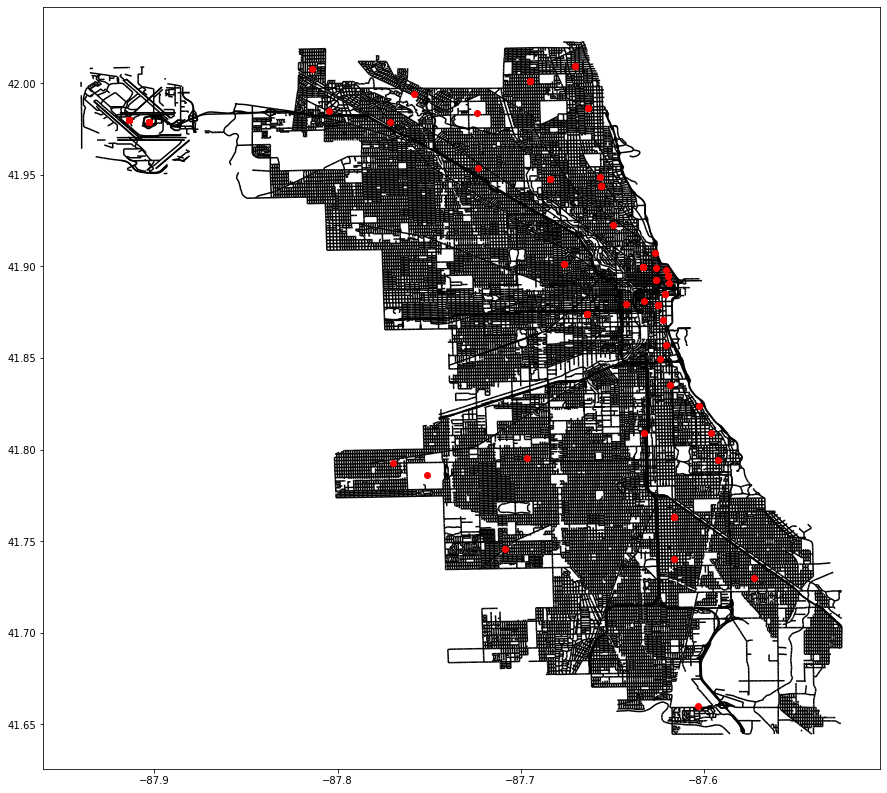

In [59]:
f,ax = plt.subplots(figsize=(15,15))
streets.plot(ax = ax, color='black')
gdf.plot(ax = ax, color='red', zorder=3)

# Grab a satellite image of Chicago using Google's Earth Engine

### Data sets

After trying a few different data sources for optical satellite images, it appears that the Sentinal S2 Surface Reflectance data set is the best option.  (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR).  It will provide RGB images at 10m resolution.  There are higher resolution image sets (e.g., https://developers.google.com/earth-engine/datasets/catalog/SKYSAT_GEN-A_PUBLIC_ORTHO_RGB), but I can't get that to work -- and it apparently only has images 2014-2016.

### Documentation

The online documention for Earth Engine is not great, especially for python.  But I've found that the javascript tutorials can also be helpful, since the syntax is very similar.  I pieced together methods from various tutorials wiht a LOT of trial and error to make this work.  

Here are valiable data sets : https://developers.google.com/earth-engine/datasets

Some tutorials can be found here: https://developers.google.com/earth-engine/tutorials/community/explore

Here's an intro in python : https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard

### Getting started

To get started, you have to install Google Earth Engine API:

```
conda install -c conda-forge earthengine-api
conda install -c anaconda pyasn1-modules
conda install -c conda-forge rasterio
```

In order to use the API you need to sign up here (link in upper right) : https://earthengine.google.com/ .  There is a short application.  When I applied, it took about 5 minutes to get access.

In [2]:
#connect to Google Earth Engine
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWgsI23bZa-sR8NkCegTEbqpsLfIc2hUE06NIbBQ6s5aBGN7fv77vPw

Successfully saved authorization token.


In [60]:
def getSentinalS2SRImage(lon, lat, sze, filename, dateMin = '2020-04-01', dateMax = '2020-04-30', vmin = 0, vmax = 3500):
    '''    
    download an RGB image from the Sentinal S2 Surface Reflectance satellite, at the given coordinates
    
    lon : central longitude in degrees
    lat : central latitude in degrees
    sze : size of the edge of the box in degrees
    dateMin : minimum date to use for image search in year-month-day (e.g., 2020-08-01)
    dateMax : maximum date to use for image search in year-month-day (e.g., 2020-08-31)
    vMin : minimum value to select in the Sentinal image pixels (I think this should be close to 0)
    vMax : maximum value to select in the Sentinal image pixels (I think this should be close to 3000)
    filename : output filename for the GeoTIFF image
    
    Note: it's possible that the vMin and vMax values should be different for each band to make the image look nicer
    
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
    '''


    print('Downloading Sentinel S2 Surface Reflectance satellite images ... ')
    
    # define the area of interest, using the Earth Engines geometry object
    coords = [
         [lon - sze/2., lat - sze/2.],
         [lon + sze/2., lat - sze/2.],
         [lon + sze/2., lat + sze/2.],
         [lon - sze/2., lat + sze/2.],
         [lon - sze/2., lat - sze/2.]
    ]
    aoi = ee.Geometry.Polygon(coords)

    bands = ['B4', 'B3', 'B2']
    # get the image using Google's Earth Engine
    db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR')\
                       .filterBounds(aoi)\
                       .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                       .sort('CLOUDY_PIXEL_PERCENTAGE')\
                       .first())
    
    # add the latitude and longitude
    db = db.addBands(ee.Image.pixelLonLat())

    # export geotiff images, these go to Drive and then are downloaded locally
    for selection in bands:
        task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                     description=selection,
                                     scale=30,
                                     region=aoi,
                                     fileNamePrefix=selection,
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
        task.start()

        url = db.select(selection).getDownloadURL({
            'scale': 30,
            'crs': 'EPSG:4326',
            'fileFormat': 'GeoTIFF',
            'region': aoi})
    
        r = requests.get(url, stream=True)

        filenameZip = selection+'.zip'
        filenameTif = selection+'.tif'

        #unzip and write the tif file, then remove the original zip file
        with open(filenameZip, "wb") as fd:
            for chunk in r.iter_content(chunk_size=1024):
                fd.write(chunk)

        zipdata = zipfile.ZipFile(filenameZip)
        zipinfos = zipdata.infolist()

        # iterate through each file (there should be only one)
        for zipinfo in zipinfos:
            zipinfo.filename = filenameTif
            zipdata.extract(zipinfo)
    
        zipdata.close()
        
    #create a combined RGB geotiff image
    #https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
    print('Creating 3-band GeoTIFF image ... ')
    
    B2 = rasterio.open('B2.tif')
    B3 = rasterio.open('B3.tif')
    B4 = rasterio.open('B4.tif')

    #get the scaling
    image = np.array([B2.read(1), B3.read(1), B4.read(1)]).transpose(1,2,0)
    p2, p98 = np.percentile(image, (2,98))

    B2_geo = B2.profile
    B2_geo.update({'count': 3})

    with rasterio.open(filename, 'w', **B2_geo) as dest:
        dest.write( (np.clip(B4.read(1), p2, p98) - p2)/(p98 - p2)*255, 1)
        dest.write( (np.clip(B3.read(1), p2, p98) - p2)/(p98 - p2)*255, 2)
        dest.write( (np.clip(B2.read(1), p2, p98) - p2)/(p98 - p2)*255, 3)

    B2.close()
    B3.close()
    B4.close()
    
    #remove the intermediate files
    for selection in bands:
        os.remove(selection + '.tif')
        os.remove(selection + '.zip')



In [61]:
#Chicago central latitude, longitude and approximate size
lat = 41.8781
lon = -87.6298
sze = 0.65
_ = getSentinalS2SRImage(lon, lat, sze, 'ChicagoGeoTIFF.tif')

Creating 3-band GeoTIFF image ... 


# Plot the final result

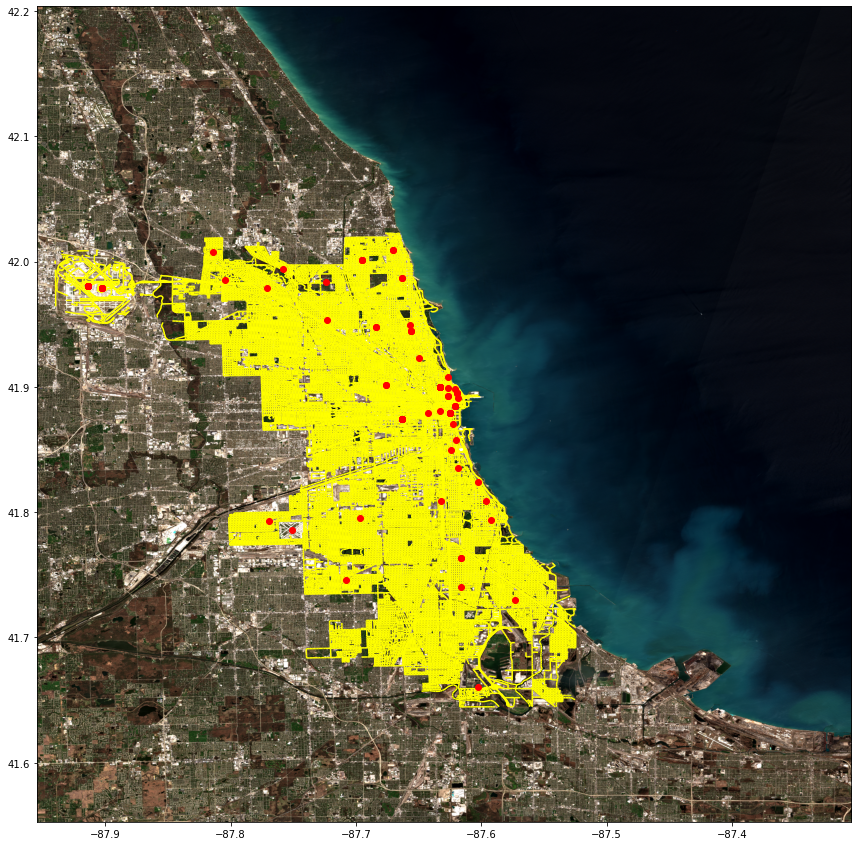

In [57]:
f,ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('ChicagoGeoTIFF.tif')
streets.plot(ax = ax, color='yellow', zorder=3)
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)
gdf.plot(ax = ax, color='red', zorder=3)

chicago.close()

In [58]:
B2.close()
B3.close()
B4.close()
chicago.close()

# Unused function for writing GeoTIFF images 

(Created while troubleshooting the map download)

In [ ]:
def createGeoTiffFromImage(img, lat, lon, sze, filename):
    '''
    Following : https://stackoverflow.com/questions/33537599/how-do-i-write-create-a-geotiff-rgb-image-file-in-python
    Take an image that has a defined central latitude, longitude and size (e.g., from a satellite image)
    and output to a GeoTIFF image with the lat and lon encoded.
    
    lon : central longitude in degrees
    lat : central latitude in degrees
    sze : size of the edge of the box in degrees

    '''

    print('Creating GeoTIFF image ... ')

    # get the image size
    width, height = img.size

    latBounds = [lat - sze/2., lat + sze/2.]
    lonBounds = [lon - sze/2., lon + sze/2.]

    # Create Each Channel
    # for some reason, this needs to be rotated wrt the satellite image
    nx = height
    ny = width
    r_pixels = np.zeros((nx, ny), dtype=np.uint8)
    g_pixels = np.zeros((nx, ny), dtype=np.uint8)
    b_pixels = np.zeros((nx, ny), dtype=np.uint8)

    # Set the Pixel Data 
    for x in range(0,nx):
        for y in range(0,ny):
            r, g, b = opim.getpixel((y, x))
            r_pixels[x,y] = r
            g_pixels[x,y] = g
            b_pixels[x,y] = b

    # set geotransform 
    xmin, ymin, xmax, ymax = [min(lonBounds), min(latBounds), max(lonBounds), max(latBounds)]
    xres = (xmax - xmin)/float(nx)
    yres = (ymax - ymin)/float(ny)
    geotransform = (xmin, xres, 0, ymax, 0, -yres)

    # create the 3-band raster file
    dst_ds = gdal.GetDriverByName('GTiff').Create(filename, ny, nx, 3, gdal.GDT_Byte)

    dst_ds.SetGeoTransform(geotransform)    # specify coords
    srs = osr.SpatialReference()            # establish encoding
    srs.ImportFromEPSG(3857)                # WGS84 lat/long
    dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    dst_ds.GetRasterBand(1).WriteArray(r_pixels)   # write r-band to the raster
    dst_ds.GetRasterBand(2).WriteArray(g_pixels)   # write g-band to the raster
    dst_ds.GetRasterBand(3).WriteArray(b_pixels)   # write b-band to the raster
    dst_ds.FlushCache()                     # write to disk
    dst_ds = None